In [1]:
import tensorflow as tf
import math
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l2
from keras.layers import BatchNormalization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

Using TensorFlow backend.


In [2]:
# read the raw data and process it

#since minutes data is too large for LSTM to process, we aggregate them into hour's mean

#there is some dates that do not trade and have no value, we drop them to make the sequence continous

file_path = "2020.5.5BTCUSD-H1-NoSession.csv"

def read_data(filepath):
                                                        
    data = pd.read_csv(filepath)
    data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'], format='%Y%m%d %H:%M:%S')
    data['y'] = np.log(data['Open']).diff()
    Filter = (data['Datetime']<"2020-01-01") & (data["Datetime"]>"2019-01-01")
    data = data[Filter]
    data = data.reset_index().drop(columns=['index','Close','High','Volume','Low'])
    data.index = data['Datetime']

    data = data.resample("H").mean()
    data = data[data['Open']>0.0001]
    data = data.drop(columns = ['Date','Open'])

    return data


data = read_data(file_path)

In [44]:
#We use previous 1 day's data to estimate 

#24*245 = 5880, which is equal to 245 days (length of data)

#total length of data = 5879

# we use 0.7/0.3 train-test split which gives us 171 train set length and 74 test


def prep_dat(d, n_step=24, n_ahead=0):


    a = d.copy()

    for i in range(1, n_step):
        ind = "t+" + str(i)
        a[ind] = a.iloc[:, 0].shift(-i)  # Use n_step historical observations to predict next quarter

    a["Q_Next"] = a.iloc[:, 0].shift(-(n_step + n_ahead))  # Next quarter(s) prediction

    a.dropna(
        inplace=True)  # last (n_step + n_ahead) rows will be NANs since shifting forward for "Next Quarter" Variable

    return (a)

# We use the past 24 hour data to predict the price for the future 1 one hour price
# For example, we collect all hourly data from 0 - 24 on 2019-01-02, and we are predicting the price for
# 1:00 on 2019-01-03

def trans_dat(data):
    pre_col = 0
    for col in data.columns:
        if pre_col == 0:
            sup_dat = prep_dat(data[[col]]).drop(columns='Q_Next').values
            sup_dat = np.expand_dims(sup_dat,axis=2)
            pre_col = col
        else:
            
            sup_dat1 = prep_dat(data[[col]]).drop(columns='Q_Next').values
            sup_dat1 = np.expand_dims(sup_dat1,axis=2)
            sup_dat = np.concatenate((sup_dat,sup_dat1),axis=2)            
            
    return sup_dat

def evaluation_model(model):
    import matplotlib.pyplot as plt
    %matplotlib inline
    history = model.history
    
    # get prediction for the model
    y_hat_train = model.predict(X_train,verbose = 0)
    y_hat_test = model.predict(X_test,verbose = 0)
    
    from sklearn.metrics import r2_score
    
    # get training and testing error
    train_mse = mean_squared_error(y_hat_train[:,0]/1000,y_train/1000)
    test_mse = mean_squared_error(y_hat_test[:,0]/1000,y_test/1000)
    r_square_train = r2_score(y_train,y_hat_train[:,0])
    r_square = r2_score(y_test,y_hat_test[:,0])
    
    print("Train set MSE is",train_mse)
    print("Test set MSE is",test_mse)
    print("Train set R Square is",r_square_train)
    print("Test set R Square is",r_square)
    
    
    # plot training loss / validation set loss, prediction versus actual value
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'],label = 'training loss')
#     plt.plot(history.history['val_loss'],label = 'validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Training loss')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_train[:100,0]/10000,label = 'prediction')
    plt.plot(y_train[:100]/10000,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.title('Train set actual/predict')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_test[:100,0]/10000,label = 'prediction')
    plt.plot(y_test[:100]/10000,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.suptitle('Test set actual/predict')
    plt.legend()
    

def split_dataset_x(data):
    # split into standard weeks
    num_features = data.shape[2]
    train =  data[0:math.floor(0.7 * len(data)),0:hidden_size,0:num_features]
    test = data[math.floor(0.7 * len(data)):-1,0:hidden_size,0:num_features]

    return train, test


def split_dataset_y(data):
    train = np.expand_dims(data[0:math.floor(0.7 * len(data))],axis = 1)
    test = np.expand_dims(data[math.floor(0.7 * len(data)):-1],axis = 1)
    return train,test

In [4]:
dataset = data
hidden_size = 24
X = trans_dat(dataset)*1000
y = prep_dat(dataset)['Q_Next']*1000
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

## Build Model

The return for training data is 
146702803.87%


The return for testing data is 
25.35%


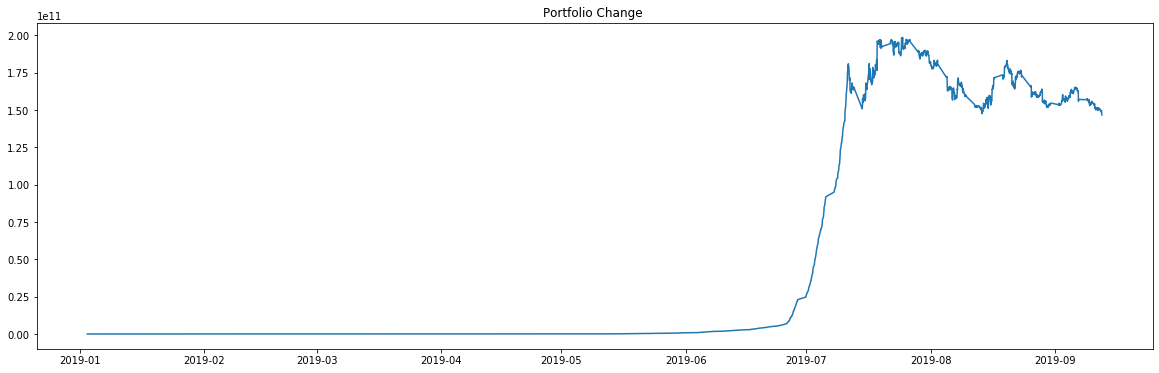

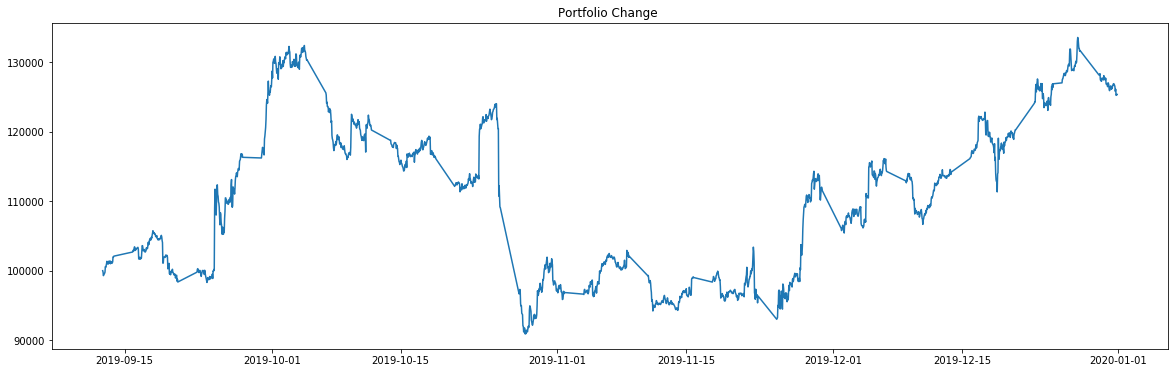

In [43]:
# this model will have exploding gradient problem and prediction will have NaN value
def build_model2(train_x,train_y,n_input):
    # prepare data
#     train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 1000, 256
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
    # define model

    model = Sequential()
    
    
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(RepeatVector(n_outputs))
    
    model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features)))

#     model.add((Dense(256,  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu')))
#     model.add(Dropout(0.1))
#     model.add((Dense(128,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')))
#     model.add((Dense(64,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu')))
#     model.add((Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu')))
#     model.add(Dropout(0.1))
#     model.add((Dense(16, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu')))
    
    model.add((Dense(256, activation='relu')))
    model.add((Dense(128, activation='relu')))
    model.add((Dense(64, activation='relu')))
    model.add((Dense(32, activation='relu')))
    model.add((Dense(16,  activation='relu')))
#     model.add(BatchNormalization())
    model.add((Dense(n_outputs)))    
    

    opt = tf.keras.optimizers.Adam()
    model.compile(loss='mse', optimizer=opt)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.25)
    return model
model2 = build_model2(X_train,y_train,24)

## Trading strategy

The return for training data is 
146702803.87%


The return for testing data is 
25.35%


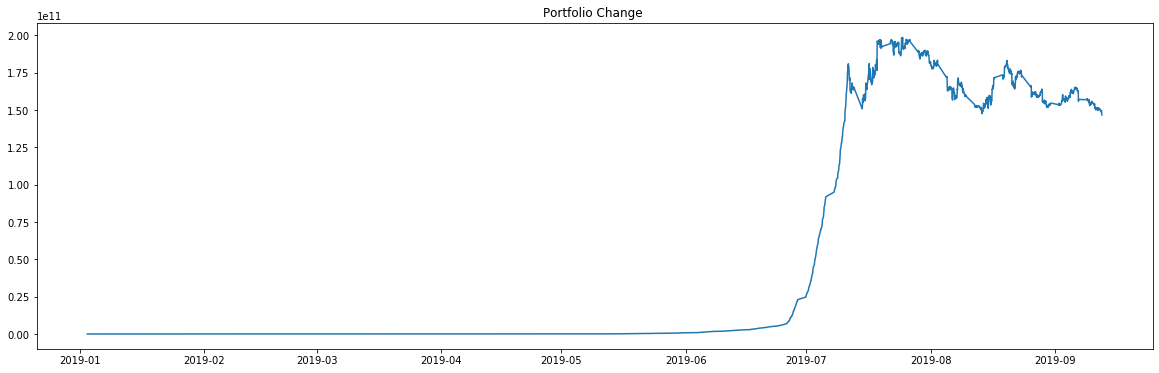

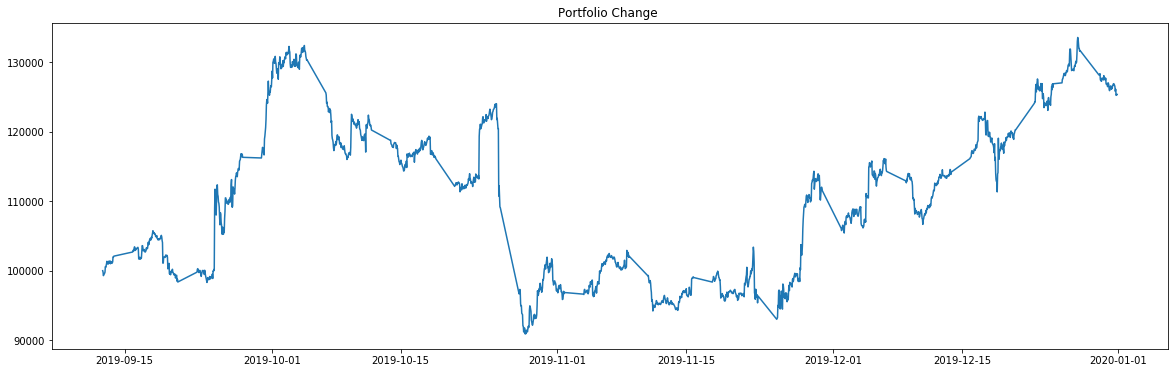

In [50]:
def read_data_test(filepath):
    data = pd.read_csv(filepath)
    data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'], format='%Y%m%d %H:%M:%S')
    data['y'] = np.log(data['Open']).diff()
    Filter = (data['Datetime']<"2020-01-01") & (data["Datetime"]>"2019-01-01")
    data = data[Filter]
    data = data.reset_index().drop(columns=['index','Close','High','Volume','Low'])
    data.index = data['Datetime']

    data = data.resample("H").mean()
    data = data[data['Open']>0.0001]
    data = data.drop(columns = ['Date'])
    return data

def strategy(model):
        
    dat = read_data_test(file_path)[24:-1]
    y_hat_train = model.predict(X_train,verbose = 0)
    y_hat_test = model.predict(X_test,verbose = 0)
    pred = np.concatenate([y_hat_train,y_hat_test])
    dat['prediction'] = pred/1000
    
    dat_train = dat[:4334]
    
    dat_test = dat[4334:]
    
    
    def evaluate_strategy(df):
        initial = 100000
        portfolio = list()
        portfolio.extend([initial])
        for i in range(len(df['prediction'])-1):
            if df['prediction'][i+1] > 0:
#                 initial -= df['Open'][i]
#                 initial += df['Open'][i+1]
                initial = initial*(df['Open'][i+1]/df['Open'][i])
                portfolio.extend([initial])
            else:
#                 initial -= df['Open'][i+1]
#                 initial += df['Open'][i]
                initial = initial*(2-df['Open'][i+1]/df['Open'][i])
                portfolio.extend([initial])
        
        
        result = (initial - 100000)/100000 * 100       
        
        plt.figure(figsize = (20,6))
        plt.plot(df.index,portfolio)
        plt.title("Portfolio Change ")
        
        print(f"{result:.2f}%")
    print("The return for training data is ")
    evaluate_strategy(dat_train)
    print("\n")
    print("The return for testing data is ")
    evaluate_strategy(dat_test)
    
strategy(model2)

Above code are used to evaluate our forecast, for LSTM method, the separation of input data and output data
are:

<li>1. Input day1, output day2
<li>2. Input [day1,day2], output day3
<li>3. Input [day1,day2,day3], output day4
<li>....

Train set MSE is 3.4601185114269714e-05
Test set MSE is 8.631013651977199e-05
Train set R Square is 0.5794902767533936
Test set R Square is -0.5654189130247049


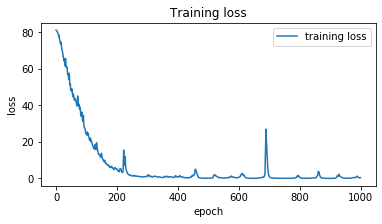

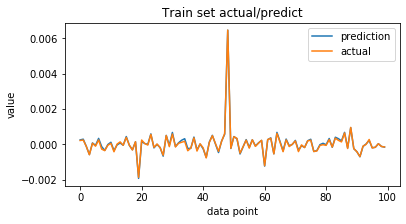

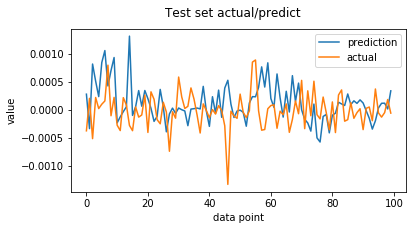

In [46]:
evaluation_model(model2)